In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import xgboost as xgb
import tensorflow as tf
from num2words import num2words
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')


In [18]:
engine = 'sqlite:///drafts1.db'
df = pd.read_sql('SELECT * FROM drafts', engine)
print(f"Loaded {len(df)} records")

Loaded 560 records


In [19]:
for col in ['bank','place_created','drawer_name','payer_name_address','amount_words']:
    df[col] = df[col].astype(str).str.strip()
for col in ['date_created','date_due']:
    df[col] = pd.to_datetime(df[col], errors='coerce')
df['amount_digits'] = pd.to_numeric(df['amount_digits'], errors='coerce')
df = df.dropna(subset=['amount_digits','date_created','date_due','rib'])
df['gap_days'] = (df['date_due'] - df['date_created']).dt.days
df['fraud_label'] = df['fraud_label'].astype(int)
df = df.drop_duplicates()
df = df[df['gap_days'] >= 0]

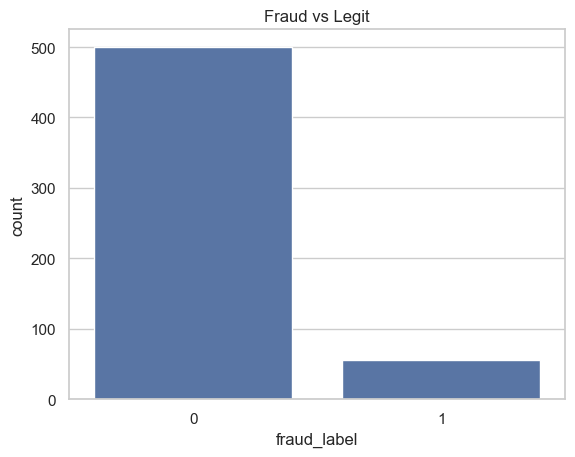

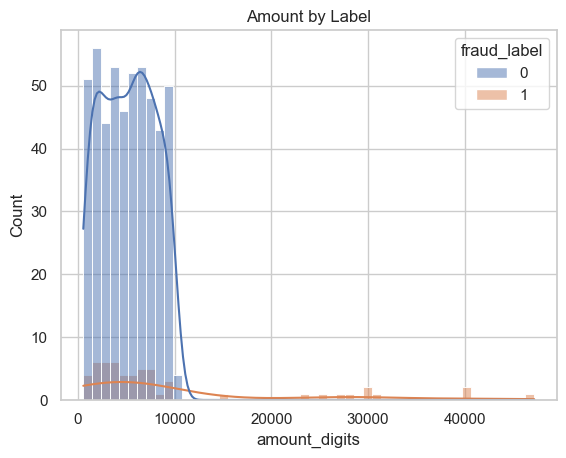

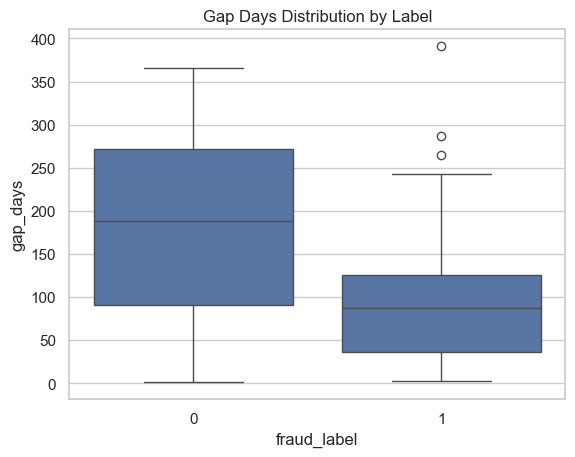

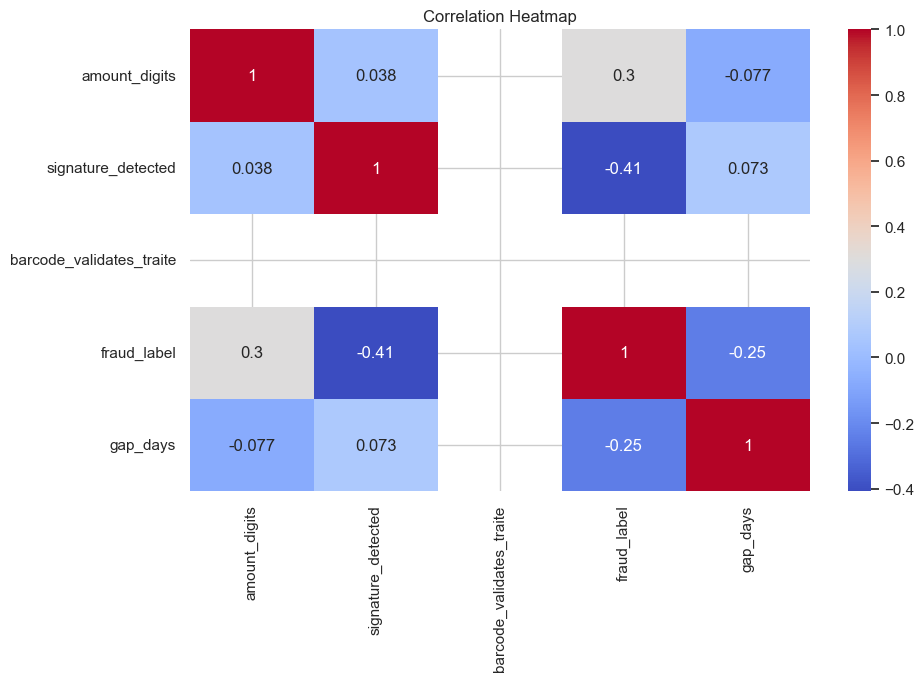

In [20]:
# Fraud count
sns.countplot(x='fraud_label', data=df)
plt.title('Fraud vs Legit'); plt.show()

sns.histplot(df, x='amount_digits', hue='fraud_label', bins=50, kde=True)
plt.title('Amount by Label'); plt.show()

sns.boxplot(x='fraud_label', y='gap_days', data=df)
plt.title('Gap Days Distribution by Label'); plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap'); plt.show()

In [21]:
rib_stats = df.groupby('rib')['amount_digits'].agg(mean_amt='mean', std_amt='std', count='count')
pop_mean, pop_std = df['amount_digits'].mean(), df['amount_digits'].std()

from num2words import num2words

def amount_to_words_fr(x): return num2words(x, lang='fr').replace('virgule','dinars zéro')

def is_valid_rib(v):
    s = ''.join(filter(str.isdigit, str(v)))
    if len(s) != 20: return False
    try:
        n = int(s[:-2] + '00'); chk = 97 - (n % 97)
        return chk == int(s[-2:])
    except: return False

In [22]:
fdf = df.copy()
fdf['words_match'] = (fdf['amount_words'] == fdf['amount_digits'].apply(amount_to_words_fr)).astype(int)
fdf['sig_missing'] = (~fdf['signature_detected']).astype(int)
fdf['barcode_bad'] = (~fdf['barcode_validates_traite']).astype(int)
fdf['rib_invalid'] = (~fdf['rib'].apply(is_valid_rib)).astype(int)
fdf['payer_len'] = fdf['payer_name_address'].str.len()>=20
fdf['drawer_len'] = fdf['drawer_name'].str.len()>=20

def compute_z(row):
    rib = row['rib']
    amt = row['amount_digits']
    if rib in rib_stats.index and rib_stats.at[rib,'count'] >= 5:
        mu = rib_stats.at[rib,'mean_amt']; sigma = rib_stats.at[rib,'std_amt']
    else:
        mu, sigma = pop_mean, pop_std
    return (amt - mu) / sigma if sigma > 0 else 0

fdf['rib_amount_z'] = fdf.apply(compute_z, axis=1)
fdf['amount_incompatible'] = (fdf['rib_amount_z'].abs() > 3).astype(int)

features = ['amount_digits','gap_days','words_match','sig_missing','barcode_bad','rib_invalid','payer_len','drawer_len','rib_amount_z','amount_incompatible']
X = fdf[features].values
y = fdf['fraud_label'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)
scale_pos = np.bincount(y_train)[0] / np.bincount(y_train)[1]

sm = SMOTE(sampling_strategy=0.3,random_state=42)
X_res, y_res = sm.fit_resample(X_train,y_train)
print(f"Resampled training set: {len(y_res)} entries, {y_res.sum()} frauds")

Resampled training set: 520 entries, 120 frauds


In [24]:
model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos,
    max_depth=5,
    learning_rate=0.1,
    n_estimators=200,
    use_label_encoder=False,
    eval_metric='logloss',
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_res,y_res)
joblib.dump(model,'xgb_model56.pkl')

C:\Users\mghir\Desktop\layoutMl\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [04:58:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


['xgb_model56.pkl']

ROC AUC: 0.8809090909090909
Best threshold by F1: 0.667


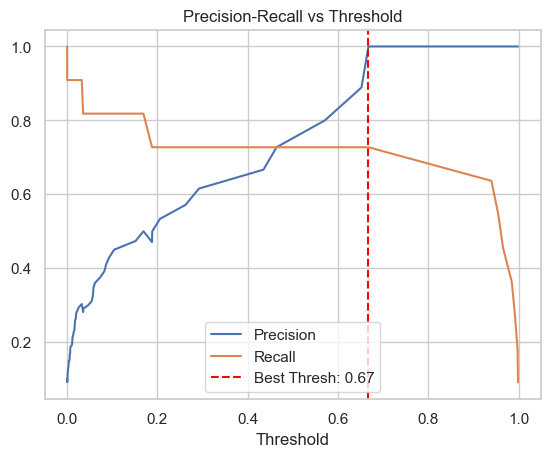

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      0.64      0.78        11

    accuracy                           0.96       111
   macro avg       0.98      0.82      0.88       111
weighted avg       0.97      0.96      0.96       111



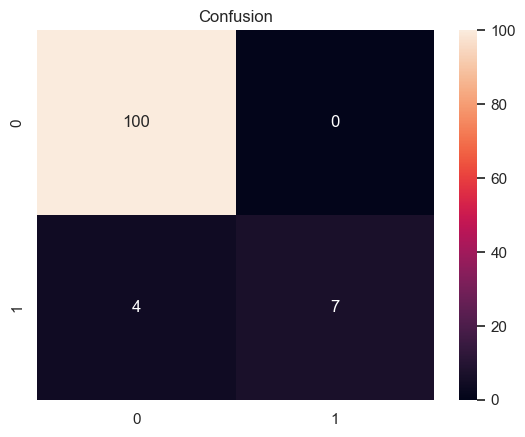

In [25]:
probs = model.predict_proba(X_test)[:,1]
print("ROC AUC:",roc_auc_score(y_test,probs))

prec,rec,thr = precision_recall_curve(y_test,probs)
f1_scores = 2*prec*rec/(prec+rec+1e-6)
best_idx = np.argmax(f1_scores)
threshold = thr[best_idx]
print(f"Best threshold by F1: {threshold:.3f}")

plt.plot(thr,prec[:-1],label='Precision'); plt.plot(thr,rec[:-1],label='Recall')
plt.axvline(threshold, color='red', linestyle='--', label=f'Best Thresh: {threshold:.2f}')
plt.xlabel('Threshold');plt.legend();plt.title('Precision-Recall vs Threshold');plt.show()

preds = (probs>threshold).astype(int)
print(classification_report(y_test,preds))
sns.heatmap(confusion_matrix(y_test,preds),annot=True,fmt='d');plt.title('Confusion');plt.show()

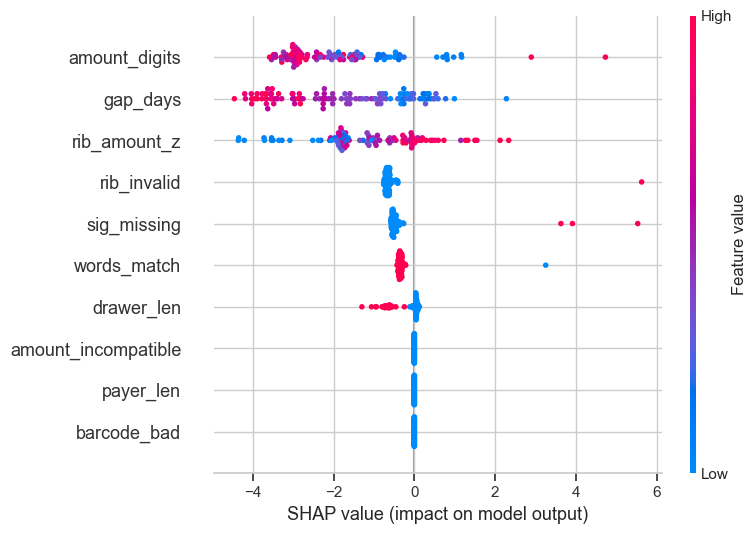

In [26]:
explainer = shap.TreeExplainer(model)
shap_vals = explainer.shap_values(X_test)
shap.summary_plot(shap_vals,X_test,feature_names=features)

In [27]:
import pandas as pd
import joblib
_xgb = joblib.load('xgb_model56.pkl')

In [28]:
# def predict_xgb(raw_input):
#     gap = (pd.to_datetime(raw_input['date_due'])-pd.to_datetime(raw_input['date_created'])).days
#     feat = [
#         raw_input['amount_digits'],gap,
#         int(raw_input['amount_words']==amount_to_words_fr(raw_input['amount_digits'])),
#         int(not raw_input['signature_detected']),
#         int(not raw_input['barcode_validates_traite']),
#         int(not is_valid_rib(raw_input['rib'])),
#         len(raw_input['payer_name_address']),
#         len(raw_input['drawer_name'])
#     ]
#     rib_amt = raw_input['amount_digits']
#     rib = raw_input['rib']
#     if rib in rib_stats.index and rib_stats.at[rib,'count'] >= 5:
#         mu = rib_stats.at[rib,'mean_amt']; sigma = rib_stats.at[rib,'std_amt']
#     else:
#         mu, sigma = pop_mean, pop_std
#     zscore = (rib_amt - mu) / sigma if sigma > 0 else 0
#     feat += [zscore, int(abs(zscore) > 3)]
#     prob = _xgb.predict_proba([feat])[0][1]
#     return {'fraud_score':round(prob,3),'fraud_label': prob>threshold}
rib_stats = df.groupby('rib')['amount_digits'].agg(mean_amt='mean', std_amt='std', count='count')
pop_mean, pop_std = df['amount_digits'].mean(), df['amount_digits'].std()

def predict_xgb(raw_input):
    gap = (pd.to_datetime(raw_input['date_due'])-pd.to_datetime(raw_input['date_created'])).days
    feat = [
        raw_input['amount_digits'],gap,
        int(raw_input['amount_words']==amount_to_words_fr(raw_input['amount_digits'])),
        int(not raw_input['signature_detected']),
        int(not raw_input['barcode_validates_traite']),
        int(not is_valid_rib(raw_input['rib'])),
        len(raw_input['payer_name_address']),
        len(raw_input['drawer_name'])
    ]
    rib_amt = raw_input['amount_digits']
    rib = raw_input['rib']
    if rib in rib_stats.index and rib_stats.at[rib,'count'] >= 5:
        mu = rib_stats.at[rib,'mean_amt']; sigma = rib_stats.at[rib,'std_amt']
    else:
        mu, sigma = pop_mean, pop_std
    zscore = (rib_amt - mu) / sigma if sigma > 0 else 0
    feat += [zscore, int(abs(zscore) > 3)]
    prob = _xgb.predict_proba([feat])[0][1]
    return {'fraud_score':round(prob,3),'fraud_label': prob>threshold}

In [29]:
import shap
explainer = shap.TreeExplainer(_xgb)
def explain_prediction(raw_input, label_text, return_vector=False):
    # Derive feature vector
    gap = (pd.to_datetime(raw_input['date_due'])-pd.to_datetime(raw_input['date_created'])).days
    feat = [
        raw_input['amount_digits'], gap,
        int(raw_input['amount_words']==amount_to_words_fr(raw_input['amount_digits'])),
        int(not raw_input['signature_detected']),
        int(not raw_input['barcode_validates_traite']),
        int(not is_valid_rib(raw_input['rib'])),
        len(raw_input['payer_name_address']),
        len(raw_input['drawer_name'])
    ]
    # z-score and incompatible
    rib = raw_input['rib']
    amt = raw_input['amount_digits']

    # Default to population stats
    if rib in rib_stats.index and rib_stats.at[rib, 'count'] >= 5:
        mu = rib_stats.at[rib, 'mean_amt']
        sigma = rib_stats.at[rib, 'std_amt']
    else:
        mu, sigma = pop_mean, pop_std
    
    # Compute z-score
    z = (amt - mu) / sigma if sigma > 0 else 0
    
    # Define incompatibility logic
    if rib in rib_stats.index and rib_stats.at[rib, 'count'] >= 5:
        incompatible = int(abs(z) > 3)
    else:
        incompatible = 0  # Do not penalize unseen/rare RIBs
    
    # Append to feature list
    feat += [z, incompatible]
    # Prediction
    prob = _xgb.predict_proba([feat])[0][1]
    print(f"--- {label_text} Prediction ---")
    print(f"Probability: {prob:.3f} -> Label: {prob>threshold}")
    # SHAP values
    shap_vals = explainer.shap_values([feat])[0]
    for name, val, sv in zip(features, feat, shap_vals):
        print(f"Feature: {name}, Value: {val}, SHAP: {sv:.3f}")
    if return_vector:
        return feat

In [30]:
legit = df[df.fraud_label == 0].sample(1).iloc[0]   # no seed
fraud = df[df.fraud_label == 1].sample(1).iloc[0]
def to_raw(r):
    return dict(
        date_created=r.date_created, date_due=r.date_due,
        amount_digits=float(r.amount_digits), amount_words=r.amount_words,
        signature_detected=bool(r.signature_detected),
        barcode_validates_traite=bool(r.barcode_validates_traite),
        rib=r.rib, payer_name_address=r.payer_name_address, drawer_name=r.drawer_name
    )
print("--- Testing Legit Example ---")
print("Derived features:", to_raw(legit))
print("Prediction:", predict_xgb(to_raw(legit)))

print("--- Testing Fraud Example ---")
print("Derived features:", to_raw(fraud))
print("Prediction:", predict_xgb(to_raw(fraud)))

--- Testing Legit Example ---
Derived features: {'date_created': Timestamp('2025-01-11 00:00:00'), 'date_due': Timestamp('2025-05-26 00:00:00'), 'amount_digits': 5531.317, 'amount_words': 'cinq mille cinq cent trente et un dinars zéro trois un sept', 'signature_detected': True, 'barcode_validates_traite': True, 'rib': '18321928554451895261', 'payer_name_address': '87, rue Dos Santos 06161 Langlois', 'drawer_name': 'Timothée Grégoire'}
Prediction: {'fraud_score': 0.683, 'fraud_label': True}
--- Testing Fraud Example ---
Derived features: {'date_created': Timestamp('2025-03-20 00:00:00'), 'date_due': Timestamp('2025-04-20 00:00:00'), 'amount_digits': 9541.893, 'amount_words': 'neuf mille cinq cent quarante et un dinars zéro huit neuf trois', 'signature_detected': True, 'barcode_validates_traite': True, 'rib': '58750663370502497287', 'payer_name_address': '14, avenue Nathalie Vasseur 43751 Sainte Caroline', 'drawer_name': 'Olivie Michaud'}
Prediction: {'fraud_score': 0.949, 'fraud_label':

In [31]:
explain_prediction(to_raw(legit), 'Legit')
explain_prediction(to_raw(fraud), 'Fraud')

--- Legit Prediction ---
Probability: 0.683 -> Label: True
Feature: amount_digits, Value: 5531.317, SHAP: -3.231
Feature: gap_days, Value: 135, SHAP: -0.813
Feature: words_match, Value: 1, SHAP: -0.305
Feature: sig_missing, Value: 0, SHAP: 4.656
Feature: barcode_bad, Value: 0, SHAP: 0.000
Feature: rib_invalid, Value: 0, SHAP: -0.482
Feature: payer_len, Value: 33, SHAP: 0.000
Feature: drawer_len, Value: 17, SHAP: -1.148
Feature: rib_amount_z, Value: -0.024464974191063128, SHAP: 0.042
Feature: amount_incompatible, Value: 0, SHAP: 0.000
--- Fraud Prediction ---
Probability: 0.949 -> Label: True
Feature: amount_digits, Value: 9541.893, SHAP: -2.421
Feature: gap_days, Value: 31, SHAP: -0.616
Feature: words_match, Value: 1, SHAP: -0.240
Feature: sig_missing, Value: 0, SHAP: 3.984
Feature: barcode_bad, Value: 0, SHAP: 0.000
Feature: rib_invalid, Value: 0, SHAP: -0.405
Feature: payer_len, Value: 49, SHAP: 0.000
Feature: drawer_len, Value: 14, SHAP: -0.597
Feature: rib_amount_z, Value: 0.989065

--- Fraud Prediction ---
Probability: 0.949 -> Label: True
Feature: amount_digits, Value: 9541.893, SHAP: -2.421
Feature: gap_days, Value: 31, SHAP: -0.616
Feature: words_match, Value: 1, SHAP: -0.240
Feature: sig_missing, Value: 0, SHAP: 3.984
Feature: barcode_bad, Value: 0, SHAP: 0.000
Feature: rib_invalid, Value: 0, SHAP: -0.405
Feature: payer_len, Value: 49, SHAP: 0.000
Feature: drawer_len, Value: 14, SHAP: -0.597
Feature: rib_amount_z, Value: 0.9890654827797826, SHAP: 1.169
Feature: amount_incompatible, Value: 0, SHAP: 0.000


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 3 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

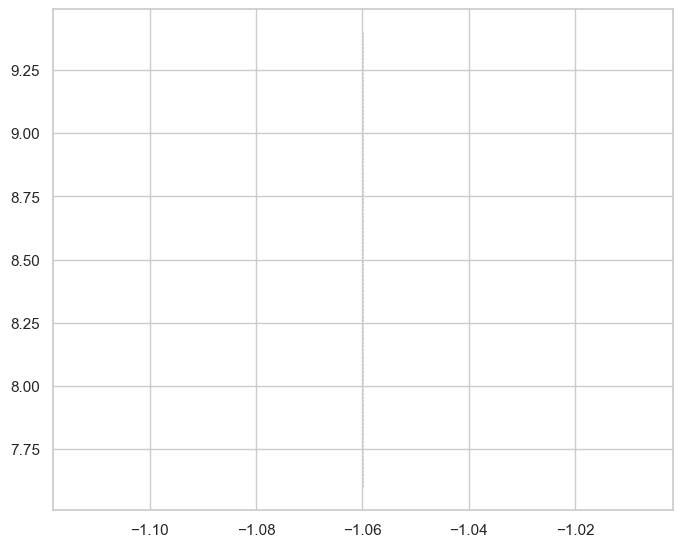

In [32]:
import shap
# Choose the feature vector for the fraud example
feat_vec = explain_prediction(to_raw(fraud), 'Fraud', return_vector=True)
# Waterfall
shap.plots.waterfall(explainer(tf.convert_to_tensor([feat_vec]))[0])
shap.summary_plot(explainer(tf.convert_to_tensor([feat_vec]))[0])


In [33]:
test1 = {
    'traite_num': "010687580474",
    'bank': 'biat',
    'amount_digits': 6776.383,
    'amount_words': 'six mille sept cent soixante-seize dinars zéro trois huit trois',
    'rib': '01050093110000158536',  # 20-digit valid RIB (example)
    'signature_detected': True,
    'barcode_validates_traite': True,
    'date_created': '2025-01-03',
    'date_due': '2025-05-26',
    'place_created': 'Tunis',
    'drawer_name': 'Client Bravo',

    'payer_name_address': 'Entreprise Alpha, 23 rue de l\'Église',
}
print("Test1 Prediction:", predict_xgb(test1))
print(explain_prediction(test1,"test1"))
    
# Custom Test 2: Suspicious Draft
test2 = {
        'date_created': '2023-12-01',
        'date_due': '2024-12-01',
        'amount_digits': 30000.00,
        'amount_words': 'trente mille dinars zéro',
        'signature_detected': False,
        'barcode_validates_traite': False,
        'rib': '98765432109876543210',  # invalid
        'payer_name_address': 'M',
        'drawer_name': 'Hc'
    }
print("Test2 Prediction:", predict_xgb(test2))
csv_line = "298196678410,Charles et Fils,6776.383,six mille sept cent soixante-seize dinars zéro trois huit trois,19431142626551104724,1,1,2025-01-03,2025-05-26,Pineauboeuf,Paul Duhamel,\"24, rue de Dumas 94621 Saint Alexandre\",0"
    
# Parse CSV
o = csv_line.split(',')
raw_test = {
        'traite_num': o[0],
        'bank': o[1],
        'amount_digits': float(o[2]),
        'amount_words': o[3],
        'rib': o[4],
        'signature_detected': bool(int(o[5])),
        'barcode_validates_traite': bool(int(o[6])),
        'date_created': o[7],
        'date_due': o[8],
        'place_created': o[9],
        'drawer_name': o[10],
        'payer_name_address': o[11].strip('"'),
        # fraud label omitted for testing
    }
print(predict_xgb(raw_test))
print("Raw CSV Parsed Input:", raw_test)
print("Prediction and Explanation:")
explain_prediction(raw_test, 'User Provided Row')

Test1 Prediction: {'fraud_score': 0.519, 'fraud_label': False}
--- test1 Prediction ---
Probability: 0.519 -> Label: False
Feature: amount_digits, Value: 6776.383, SHAP: -2.687
Feature: gap_days, Value: 143, SHAP: -1.017
Feature: words_match, Value: 1, SHAP: -0.295
Feature: sig_missing, Value: 0, SHAP: 4.896
Feature: barcode_bad, Value: 0, SHAP: 0.000
Feature: rib_invalid, Value: 0, SHAP: -0.508
Feature: payer_len, Value: 36, SHAP: 0.000
Feature: drawer_len, Value: 12, SHAP: -0.920
Feature: rib_amount_z, Value: 0.24435214419485565, SHAP: -1.441
Feature: amount_incompatible, Value: 0, SHAP: 0.000
None
Test2 Prediction: {'fraud_score': 1.0, 'fraud_label': True}
{'fraud_score': 0.519, 'fraud_label': False}
Raw CSV Parsed Input: {'traite_num': '298196678410', 'bank': 'Charles et Fils', 'amount_digits': 6776.383, 'amount_words': 'six mille sept cent soixante-seize dinars zéro trois huit trois', 'rib': '19431142626551104724', 'signature_detected': True, 'barcode_validates_traite': True, 'dat